<a href="https://colab.research.google.com/github/othmane42/defi1_hackAI/blob/main/3_Input_classification_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [ ]:
# ?????????????????????????????????????
# ?????????????????????????????????????

# **2. Importation des librairies**

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2 
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.vgg19 import VGG19, preprocess_input #224*224
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image
from google.colab import files
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

ModuleNotFoundError: No module named 'google.colab'

#**3. Téléchargement des données d'entrainement "Small Dataset"**

In [77]:
def seed_everything(seed=0):
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"]=str(seed)
    np.random.seed(seed)
    
# seeding the enviorment to have reproducable results.

seed_everything()
#tf.config.experimental.enable_op_determinism()


In [4]:
bases_path_after="bases1"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

In [5]:
!wget --no-check-certificate https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_1.tar
!tar xf FIRE_DATABASE_1.tar  -C 'bases1' --one-top-level


--2022-11-25 11:48:40--  https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_1.tar
Resolving cluster.ig.umons.ac.be (cluster.ig.umons.ac.be)... 193.190.209.220
Connecting to cluster.ig.umons.ac.be (cluster.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 466772992 (445M) [application/octet-stream]
Saving to: ‘FIRE_DATABASE_1.tar’

FIRE_DATABASE_1.tar 100%[===================>] 445.15M  6.73MB/s    in 65s     

2022-11-25 11:49:45 (6.85 MB/s) - ‘FIRE_DATABASE_1.tar’ saved [466772992/466772992]



#**4. Téléchargement des données de test "Test Dataset"**

In [61]:
!rm -rf sample_data
!wget --no-check-certificate http://195.154.53.219/downloads/test.tar
!tar xf test.tar -C 'bases' --one-top-level
!rm test.tar

--2022-11-17 20:12:39--  http://195.154.53.219/downloads/db3.tar
Connecting to 195.154.53.219:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-11-17 20:12:40 ERROR 404: Not Found.

tar: test.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


#**5. Création du fichier de labels "classes.txt"**

In [2]:
!echo '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**6. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [ ]:
!ls bases/

big  test


In [78]:
nb_classes = 3
batch_size=8 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=20 #@param [5, 10,20,50,100,200] {type:"raw"}
#dataset_path = "bases/"
dataset_path= "bases_"
input_dim=224 #@param [224,299] {type:"raw"}  
dataset_name = "FIRE_DATABASE_3" #@param ["small", "big", "DB2", "DB3"]
train_dataset = os.path.join(dataset_path, dataset_name)
test_name='test' #@param ["test","test1","test2","test3"]
test_dataset = os.path.join(dataset_path, test_name)
classes_path = "classes.txt"
classifier = "DenseNet201" #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}


# **7. Compter le nombre de classes**

In [71]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **8. Création du jeu de données d'entraînement  (A COMPLETER)**

In [72]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
    #    rescale=1./255,
    #    zca_whitening=True,
    #    zca_epsilon=1e-06,
        brightness_range=[0.2,1],
        fill_mode='nearest',
        vertical_flip=False,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)


# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dataset,  # this is the target directory
        target_size=(input_dim,input_dim),  # all images will be resized to 150x150
        batch_size=batch_size,
        seed=42,
        subset="training",
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = train_datagen.flow_from_directory(
        train_dataset,
        target_size=(input_dim,input_dim),
        seed=42,
        subset="validation",           # Sélection du jeu de données d'entraînement
        batch_size=batch_size,
        class_mode='categorical')

Found 1200 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


#**9. Créer le jeu de validation (A COMPLETER : même générateur, One-Hot, jeu "validation")**

# **10. Télécharger un modèle préentraîné et appliquer le Transfer Learning**



In [10]:
!python -m pip install keras==2.9.0

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.9.0 which is incompatible.
tensorflow-gpu 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.9.0 which is incompatible.

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [11]:
import keras
keras.__version__

'2.8.0'

In [80]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet50
from keras.applications.resnet_v2 import  ResNet152V2, ResNet50V2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications import MobileNetV2
from keras.applications.densenet import DenseNet201
from keras import activations

#base_model = MobileNet(include_top=False,weights="imagenet",input_shape=(input_dim,input_dim,3))
base_model = InceptionV3(include_top=False,weights="imagenet",input_shape=(input_dim,input_dim,3))
#base_model = MobileNetV2(include_top=False,weights="imagenet",input_shape=(input_dim,input_dim,3))
#base_model = VGG16(include_top=False,weights="imagenet",input_shape=(input_dim,input_dim,3))
#base_model = DenseNet201(include_top=False,weights="imagenet",input_shape=(input_dim,input_dim,3))

for layer in base_model.layers:
  layer.freeze=True

x=base_model.output
x=GlobalAveragePooling2D()(x)

x= Dense(512,activation="relu")(x)
# x= Dense(256,activation="relu")(x)
# x= Dense(128,activation="relu")(x)
# x= Dense(64,activation="relu")(x)


# x = Dropout(0.425)(x)
y = Dense(nb_classes,activation="softmax")(x)

model = Model(inputs=base_model.input,outputs=y)

87924736/87910968 [==============================] - 20s 0us/step


# **11. Geler puis dégeler les poids des premières couches**

# **11. Compiler le modèle avec la descente de gradient stochastique DSG**


In [81]:
# recompiler le modèle
#model.compile(loss="CategoricalCrossentropy",optimizer="sgd",metrics=["accuracy"])
model.compile(loss="CategoricalCrossentropy",optimizer="adam",metrics=["accuracy"])

# **12. Entraîner le modèle**

In [82]:

seed_everything()
# tf.config.experimental.enable_op_determinism()
#"/content/drive/MyDrive/MyModels/groupe_15_model_DenseNet201.h5
model_cp = ModelCheckpoint("./groupe_15_model_inceptionv3.h5",monitor="val_accuracy",save_best_only=True,verbose=1)

early_stopping = EarlyStopping(monitor="val_accuracy",patience=7)

history=model.fit(train_generator,validation_data=validation_generator,epochs=25,callbacks=[model_cp,early_stopping],shuffle=False)


Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
150/150 [==============================] - ETA: 0s - loss: 0.7247 - accuracy: 0.7542WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fdce01715f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set th

#**13. Sauvegarder le modèle final (A COMPLETER)**


In [83]:
model.save("final_model.h5")

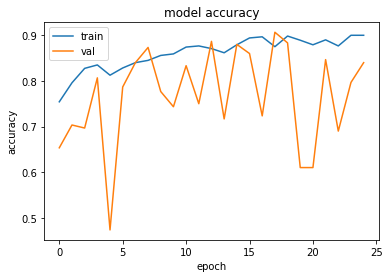

In [84]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **15. Créer le jeu de données de test**

In [87]:
# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
# 	test_dataset,               # chemin vers le jeu de données
# 	seed=42,                     # Initialisation du générateur aléatoire (permutations)
# 	image_size=(input_dim,input_dim),   # Taille des images d'entrée
# 	batch_size=32,
#   shuffle=False,   # Taille du mini-batch
#   label_mode="categorical"    # Conversion au format One-Hot
# )

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
        "bases/test",  # this is the target directory
        target_size=(input_dim,input_dim),  # all images will be resized to 150x150
        batch_size=1,
        seed=42,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels



Found 210 images belonging to 3 classes.


In [88]:
type(test_generator)


keras.preprocessing.image.DirectoryIterator

In [89]:
import tqdm
y_test = []
for image , label in tqdm.tqdm(test_generator):
    y_test.append(label)
    if len(y_test)==len(test_generator):
        break

y_test = np.array(y_test)

100%|█████████▉| 209/210 [00:06<00:00, 34.62it/s]


(210, 3)

# **16. Evaluer le modèle avec ce jeu de données de test**

In [90]:
model.load_weights("./groupe_15_model_inceptionv3.h5")

In [ ]:
model.load_weights("/content/drive/MyDrive/MyModels/resnet50_f_checkpoint.h5")

In [91]:
model.evaluate(test_generator)

210/210 [==============================] - 11s 44ms/step - loss: 0.3114 - accuracy: 0.8381


[0.3113979995250702, 0.8380952477455139]

In [53]:
import keras

model2 = keras.models.load_model('/mnt/c/Users/othma/Downloads/best_checkpoint.h5')

In [54]:
model2.compile(loss="CategoricalCrossentropy",optimizer="adam",metrics=["accuracy"])

In [55]:
y_pred  = model2.predict(test_generator)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [27]:
y_pred.shape

(210, 3)

In [56]:
from sklearn import metrics
matrix = metrics.confusion_matrix(y_test.squeeze().argmax(axis=1), y_pred.argmax(axis=1))

[Text(0, 0.5, 'fire'), Text(0, 1.5, 'no fire'), Text(0, 2.5, 'start fire')]

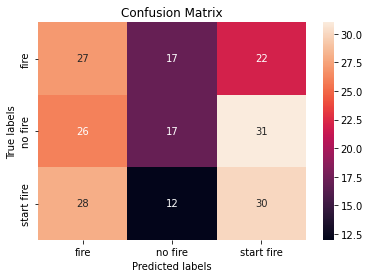

In [57]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['fire', 'no fire','start fire']) 
ax.yaxis.set_ticklabels(['fire', 'no fire','start fire'])

with last checkpoint

In [ ]:
model.evaluate(test_generator)

with best checkpoint

In [ ]:
!unzip  "/content/drive/MyDrive/dataset_fire/archive (1).zip" -d /content/drive/MyDrive/dataset_fire/dataset_aux

In [ ]:
!cp /content/drive/MyDrive/dataset_fire/dataset_aux/ForestFireDataset/Training/fire/* /content/drive/MyDrive/dataset_fire/small/fire/ 

In [ ]:
!cp /content/drive/MyDrive/dataset_fire/dataset_aux/ForestFireDataset/Training/nofire/* /content/drive/MyDrive/dataset_fire/small/no_fire/ 

In [ ]:
!cp -r bases/ drive/MyDrive/dataset_fire

In [ ]:
!cp best_checkpoint.h5 drive/MyDrive/InceptionV3_checkpoint.h5

In [ ]:
!cp final_model.h5 drive/MyDrive/Xception_checkpoint__.h5

In [ ]:
model.evaluate(test_generator)

#**16. Tester le modèle avec une image de test: "fire.jpg" et "no_fire.jpg (A COMPLETER)"**

In [ ]:
files.upload()

In [ ]:
train_ds.class_names

In [ ]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "/content/bases/test/start_fire/test104.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(224,224))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()